In [48]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [49]:
X, y = mnist['data'], mnist['target']

In [50]:
#Having a look at a digit by reshaping the image to a 28x28
import matplotlib as mpl
import matplotlib.pyplot as plt

In [51]:
X2 = X.to_numpy()

In [52]:
import numpy as np
import pandas as pd
some_digit = X2[0].reshape(28,28)
some_digit2 = X2[1].reshape(28,28)
tot = np.concatenate((some_digit,some_digit2),axis=1)

(-0.5, 55.5, 27.5, -0.5)

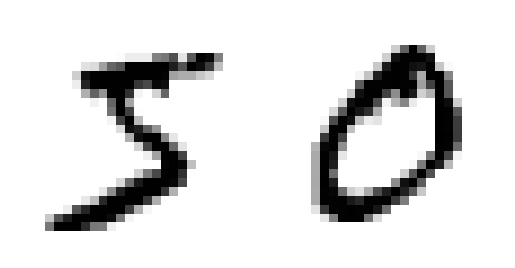

In [53]:
plt.imshow(tot, cmap='binary')
plt.axis('off')

In [54]:
print(y[0])

5


In [55]:
y = y.astype(int)

In [56]:
a1 = np.array([[1,2],[5,6]]); a2 = np.array([[3,4],[7,8]])
np.concatenate((a1,a2), axis=1)

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [57]:
#splitting between training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [58]:
#Let's train a binary classifier for number 5
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [59]:
y_train_5

0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

In [60]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [61]:
sgd_clf.predict(X_train)

array([ True, False, False, ...,  True, False, False])

In [62]:
#Implementing a manual* Cross-Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score
strat_kfold = StratifiedKFold(n_splits=3, shuffle= True, random_state=42)

for train_index, test_index in strat_kfold.split(X_train, y_train_5):
    X_train_fold = X_train.iloc[list(train_index)]
    y_train_fold = y_train_5.iloc[list(train_index)]
    X_test_fold = X_train.iloc[list(test_index)]
    y_test_fold = y_train_5.iloc[list(test_index)]
    sgd_clf.fit(X_train_fold, y_train_fold)
    y_hat = sgd_clf.predict(X_test_fold)
    print(accuracy_score(y_hat, y_test_fold))
    #print(sum(y_hat == y_test_fold)/y_hat.size)

0.9669
0.91625
0.96785


In [63]:
#Using Cross-Validation
from sklearn.model_selection import cross_val_score
cvs=cross_val_score(sgd_clf,X_train,y_train_5,cv=3)

In [64]:
print(cvs)

[0.95035 0.96035 0.9604 ]


##### The problem is that even a dummy classifier might perform well if there are not so many 5s

In [65]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, Y=None):
        return self
    def transform(self,X):
        return np.zeros(len(X), dtype = bool) #this is not necessary as it's the same of predict
    def predict(self,X):
        return np.zeros(len(X), dtype = bool)
    

In [66]:
trial = Never5Classifier()
cross_val_score(trial,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [67]:
#The confusion matrix is a way to deal with classification accuracy [[TN, FP], [FN, TP]]
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [68]:
y_train_pred.size

60000

In [69]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_pred,y_train_5)

array([[53892,  1891],
       [  687,  3530]], dtype=int64)

### The values in the confusion matrix one can obtain are Precision and Recall
#### Precision is TP/(TP + FP)
#### Recall is TP/(TP + FN)

In [70]:
from sklearn.metrics import recall_score, precision_score
print('Recall:', recall_score(y_train_pred,y_train_5))
print('Precision:', precision_score(y_train_pred,y_train_5))

Recall: 0.8370879772350012
Precision: 0.6511713705958311


In [71]:
#The harmonic mean of both values is calles the F_1 score
from sklearn.metrics import f1_score
f1_score(y_train_pred,y_train_5)

0.7325171197343846